# NLP for Loan Description

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
# Load desc
accepted = pd.read_csv('./data/desc.csv', low_memory=False)

In [3]:
# Preprocessing for NLP
pd.set_option('display.max_columns', 200)
pd.set_option('max_colwidth', 200)

desc = accepted[~accepted['desc'].isnull()][['loan_status', 'desc']]
desc['desc'] = desc['desc'].str.replace('<br>', ' ')
desc['desc'] = desc['desc'].str.replace('<br/>', ' ')
desc['desc'] = desc['desc'].str.replace('"', ' ')
desc['desc'] = desc['desc'].str.replace('\t|\n', ' ')
desc['desc'] = desc['desc'].str.replace('Borrower added on \d+\/\d+\/\d+ >', ' ')
desc['desc'] = desc['desc'].str.replace(' +', ' ')
desc['desc'] = desc['desc'].str.strip()
desc = desc[desc['desc'] != '']
desc = desc[desc['loan_status'] != 'Current'] # remove 'Current' because this is not final status.

desc = desc[(desc['loan_status'] == 'Fully Paid') | (desc['loan_status'] == 'Charged Off') | (desc['loan_status'] == 'Default')]
desc = desc.assign(fully_paid = np.where(desc['loan_status'].str.contains('Fully Paid'), 1, 0))
desc.head(10)

,loan_status,desc,fully_paid
1480,Fully Paid,"We knew that using our credit cards to finance an adoption would squeeze us, but then medical and other unexpected expenses made the situation almost impossible. We are a stable family in a stable...",1
33065,Fully Paid,"I had a bad year two years ago, with some late and missed payments. I'm doing much better now, but I've got fees and some higher interest bits that have added up on top of the other stuff, and it'...",1
37860,Fully Paid,"Lenders, I have the ability to pay off my current debt but, would like the ability to be able to put some extra money off to the side and build my personal savings account. The lower interest rate...",1
50494,Fully Paid,"I paid off my first Prosper loan, but had an emergency and took out a second Prosper loan, but at a very high interest rate - and I would like the opportunity to get the interest rate lowered. Thi...",1
68327,Fully Paid,I want to cut down on my credit card debt now (while they are not wildly out of control) by consolidating them all in one so I can make regular payments to one single source rather than keeping on...,1
73176,Fully Paid,i recently proposed to my girlfriend of almost 8 yrs now and everything was going well untill our pug (ody) the middle of my three dogs started limping around and stumbling all the time. well come...,1
122447,Fully Paid,I would like to consolidate my loan in one small monthly payment w/a low interest rate. All my credit has a very high interest rate. Please advise and let me know if i will be qualified.,1
165720,Fully Paid,I have excellent credit and I need to reduce my credit card debt at a lower interest rate.,1
185278,Fully Paid,I have been in business for a year and want to eliminate some personal debt and use the remainder of the loan to take care of business expenses. Also lessening the number of trade lines I have ope...,1
245825,Fully Paid,I am building a new garage on a property that i ocupy as my primary residence. I just purchased the propery in June 2007 and my bank will only offer a peronnal loan a a ridculus high interst rate ...,1


In [4]:
desc['fully_paid'].value_counts() # imbalance (need under or over sampling)

1    104390
0     18904
Name: fully_paid, dtype: int64

In [5]:
# under sampling
sample = desc[desc['fully_paid'] > 0].sample(len(desc[desc['fully_paid'] == 0]), replace=False)
sample = sample.append(desc[desc['fully_paid'] == 0])
sample['fully_paid'].value_counts()

1    18904
0    18904
Name: fully_paid, dtype: int64

In [6]:
# NLP
X_train, X_test, Y_train, Y_test = train_test_split(sample['desc'], sample['fully_paid'], shuffle=True, test_size=0.2)

grid_params = {
    'alpha': np.linspace(0.1, 20.0, 50),
    'fit_prior': [True, False]
}

tfidf_vec = TfidfVectorizer(min_df=10, stop_words='english',ngram_range=(1, 2))
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

text_clf = MultinomialNB()
gs_clf_svm = GridSearchCV(text_clf, grid_params, n_jobs=-1, cv=5)
gs_clf_svm.fit(X_train_tfidf, Y_train)

print(gs_clf_svm.best_params_)

pred = gs_clf_svm.predict(X_test_tfidf)

# accuracy
print(np.mean(pred == Y_test))

cm = confusion_matrix(Y_test, pred)

{'alpha': 17.56326530612245, 'fit_prior': False}
0.5756413647183285


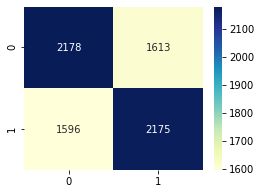

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [0, 1], columns = [0, 1])
plt.figure(figsize = (4,3))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')

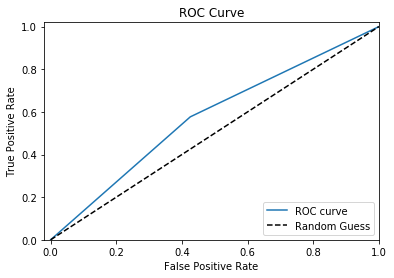

In [9]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(Y_test, pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.xlim([-0.02, 1])
plt.ylim([0, 1.02])
plt.legend(loc='lower right')